# Prediction of One Droplets (RNN based)
- Condition
    - paraffin: 20
    - ES volume: 10
    - n_droplets: 1
    - Dye conc.: 0.005
    - SDS conc.: 15
    - Solution volume: 30
    - Temp.: 25

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary # ニューラルネットワークの中身を見る

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import os
import random

from callback import earlystopping

# 乱数固定用の処理
# 同じ学習結果を得る
seed = 10


os.environ['PYTHONHASHSEED'] = str(seed)
# Python random
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# df = pd.read_table("230724/pos-0.dat", sep=" ",header=None)

def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=3, axis=1)
    return df

df = mk_dataframe("230724/pos-1.dat")

In [3]:
df.head()

,1,2
0,-3.232773,5.288970
1,-3.228381,5.299143
2,-3.213599,5.306022
3,-3.234857,5.278095
4,-3.210847,5.306227


In [4]:
df_ = df.values

In [5]:
df_

array([[-3.23277253,  5.28896996],
       [-3.22838095,  5.29914286],
       [-3.21359912,  5.30602203],
       ...,
       [26.22246288, 14.94856769],
       [26.222075  , 14.964675  ],
       [26.19685408, 14.93190987]])

In [6]:
df[::-1]

,1,2
35999,26.196854,14.931910
35998,26.222075,14.964675
35997,26.222463,14.948568
35996,26.210261,14.977071
35995,26.203872,14.979894
...,...,...
4,-3.210847,5.306227
3,-3.234857,5.278095
2,-3.213599,5.306022
1,-3.228381,5.299143


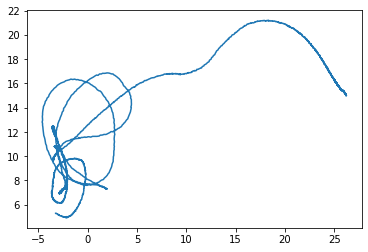

In [7]:
plt.plot(df_[:36000:10, 0], df_[:36000:10, 1])

In [8]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

df_scaled = scaler.fit_transform(df_)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## データ分割
1秒ごとに最初の36000データを使用（うち80%をtrainに使用)

In [29]:
df_for_pred = df_scaled[:36000:10]

# reversed ========================
df_for_pred = np.copy(df_for_pred[::-1])
# =================================

train_size = int(len(df_for_pred) * 0.8)
test_size = len(df_for_pred) - train_size

print("n train: {}, n test:{}".format(train_size, test_size))

n train: 2880, n test:720


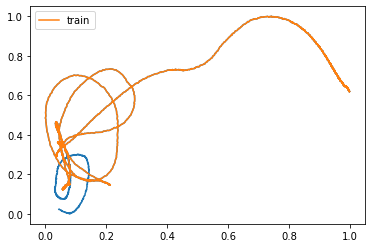

In [30]:
plt.plot(df_for_pred[:, 0], df_for_pred[:, 1])

plt.plot(df_for_pred[:train_size, 0], df_for_pred[:train_size, 1], label="train")
plt.legend()

In [31]:
# 何個のデータを用いて次の時刻を予測
time_step = 8
n_sample = train_size - time_step - 1

#シーケンシャルデータを格納する箱を用意(入力)
input_data = np.zeros((n_sample, time_step, 2))
#シーケンシャルデータを格納する箱を用意(正解)
correct_input_data = np.zeros((n_sample, 2))

print(input_data.shape)
print(correct_input_data.shape)

(2871, 8, 2)
(2871, 2)


In [32]:
for i in range(n_sample):
    input_data[i] = df_for_pred[i:i+time_step, :].reshape(-1, 2)
    correct_input_data[i] = df_for_pred[i+time_step:i+time_step+1, :]

In [33]:
# -----データローダ-----
input_data = torch.tensor(input_data, dtype=torch.float) #Tensor化(入力)
correct_data = torch.tensor(correct_input_data, dtype=torch.float) #Tensor化(正解)

dataset = torch.utils.data.TensorDataset(input_data, correct_data) #データセット作成

n_sample_train = len(dataset)
n_train = int(n_sample * 0.8)
n_val = n_sample_train - n_train

print("n_train:{}, n_val:{}".format(n_train, n_val))

train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                           [n_train, n_val], 
                                                           generator=torch.Generator().manual_seed(seed))

# ------データローダの再現性担保-----
def seed_worker(worker_id):
    worker_seed = torch.initial_seed()

    # Seed other libraries with torch's seed
    random.seed(worker_seed)

    # Numpy seed must be between 0 and 2**32 - 1
    if worker_seed >= 2 ** 32:
        worker_seed = worker_seed % 2 ** 32
    np.random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)
# -------------------------------


# datasetからバッチごとに取り出す
train_loader = DataLoader(
                            train_dataset,
                            batch_size=100,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=torch.Generator().manual_seed(seed),
                        )

val_loader = DataLoader(
                            val_dataset,
                            batch_size=100,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=torch.Generator().manual_seed(seed),
                        )

n_train:2296, n_val:575


**memo**  dataset = torch.utils.data.TensorDataset(input_data, correct_data) #データセット作成
バッチサイズ --> データを何個で1セットとみなすか  
Dataloaderの処理 --> バッチをすべてのデータを使用するまで作る

In [34]:
# xx = 0
# for (x,t) in train_loader:
#     if xx == 0:
#         print(x)
#         print(t)
#     x += 1

In [35]:
class GRU(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(GRU, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # 重みの初期値設定 --> 勾配消失を防ぐ
        nn.init.xavier_normal_(self.gru.weight_ih_l0)
        nn.init.orthogonal_(self.gru.weight_hh_l0)
        
    def forward(self, x):
        y_gru, h = self.gru(x, None)
        y = self.fc(y_gru[:, -1, :])
        
        return y

## 学習

In [36]:
def train_func(net, epoch=100):
    loss_func = nn.MSELoss(reduction="mean")

    optimizer = optim.Adam(net.parameters(), lr=0.001)

    device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")  #デバイス(GPU or CPU)設定 
    
    hist = {"train_loss":[], 
            "val_loss":[]}

    epochs = 100 #エポック数

    net.to(device)

    es = earlystopping.EarlyStopping(patience=5, verbose=1)
    
    for i in range(epochs):
        net.train()
        running_loss = 0.0
        running_val_loss = 0.0

        for j, (x, t) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()

            y = net(x)
            y = y.to(device)

            loss = loss_func(y, t)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

        running_loss /= j + 1
        hist["train_loss"].append(running_loss)
        
        for j, (x, t) in enumerate(val_loader):
            x, t = x.to(device), t.to(device)
            
            net.eval()
            
            pred = net(x)
            loss = loss_func(pred, t)
            running_val_loss += loss.item()
            
        running_val_loss /= j + 1
        hist["val_loss"].append(running_val_loss)


        if i%5 == 0 or i==epochs-1:
            print("Epoch:{}, Train_Loss:{:3f}, Val_Loss:{:3f}".format(i, running_loss, running_val_loss))

        if es(running_val_loss):
            print("Epoch:{}, Train_Loss:{:3f}, Val_Loss:{:3f}".format(i, running_loss, running_val_loss))
            break
    
    #lossの推移を確認
    plt.plot(range(len(hist["train_loss"])), hist["train_loss"], label='train loss')
    plt.plot(range(len(hist["val_loss"])), hist["val_loss"], label='val loss')
    
    plt.legend()
    plt.title("Change of Loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

## 予測用関数

In [37]:
def future_prediction(net, data, start=train_size, pred_len=test_size):
    """
    Args:
        net: model to use
        data: dataset to use
        start: start prediction at this point
        pred_len: how many seconds the model predict
    """
    X = data
    net.eval()

    gen = [[None, None] for i in range(start)] # 予測値を時系列で保持するためのリスト

    z = X[start:start+time_step].reshape(-1, time_step, 2) # 予測用に未知の部分の最初10個
    
    # z = X[:time_step].reshape(-1, time_step, 2) # 予測用に最初の50データを与える
    
    # pred_lenは何回予測を繰り返すか＝何秒後まで予測するか
    for i in range(pred_len):
        z_ = torch.Tensor(z[-1:, :])

        preds = net(z_).data.cpu().numpy()
        z = np.concatenate([z, preds.reshape(-1, 1, 2)], 1)
        z = z[:,1:,:]

        gen.append([preds[0,0], preds[0,1]])
        
    print(net)

    plt.plot(X[:,0], X[:,1], label="Correct", alpha=0.6)
    plt.plot(X[:train_size,0], X[:train_size,1], label="train data")

    gen = np.array(gen)
    plt.plot(gen[:,0], gen[:,1],label='Predicted', color="green")
    plt.legend()

    plt.scatter(X[start+time_step,0], X[start+time_step,1], marker="x")
    # plt.scatter(X[train_size+time_step,0], X[train_size+time_step,1], marker="x")
    plt.title("hidden_dim={} \n start prediction at {} s".format(net.hidden_dim, start))
    
    # plt.savefig("outputs/1droplet/pred_1droplts_hdim{}_at{}.png".format(net.hidden_dim, start))
    plt.show()
    
    return gen

In [18]:
test_size

720

## Define model

In [39]:
input_dim = 2
output_dim = 2
hidden_dim = 32
n_layers = 1

torch.manual_seed(seed)
net = GRU(input_dim, output_dim, hidden_dim, n_layers)

batch_size = 256
summary(net, (batch_size, time_step, 2))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [256, 2]                  --
├─GRU: 1-1                               [256, 8, 32]              3,456
├─Linear: 1-2                            [256, 2]                  66
Total params: 3,522
Trainable params: 3,522
Non-trainable params: 0
Total mult-adds (M): 7.09
Input size (MB): 0.02
Forward/backward pass size (MB): 0.53
Params size (MB): 0.01
Estimated Total Size (MB): 0.56

Epoch:0, Train_Loss:0.272087, Val_Loss:0.101534
Epoch:5, Train_Loss:0.003424, Val_Loss:0.003046
Epoch:10, Train_Loss:0.000797, Val_Loss:0.000596
Epoch:15, Train_Loss:0.000116, Val_Loss:0.000101
Epoch:20, Train_Loss:0.000093, Val_Loss:0.000086
Epoch:25, Train_Loss:0.000082, Val_Loss:0.000077
Epoch:30, Train_Loss:0.000074, Val_Loss:0.000070
Epoch:35, Train_Loss:0.000067, Val_Loss:0.000065
Epoch:40, Train_Loss:0.000063, Val_Loss:0.000061
Epoch:45, Train_Loss:0.000058, Val_Loss:0.000055
Epoch:50, Train_Loss:0.000056, Val_Loss:0.000053
Epoch:55, Train_Loss:0.000053, Val_Loss:0.000050
Epoch:60, Train_Loss:0.000050, Val_Loss:0.000048
Epoch:65, Train_Loss:0.000048, Val_Loss:0.000046
Epoch:70, Train_Loss:0.000047, Val_Loss:0.000044
Epoch:75, Train_Loss:0.000044, Val_Loss:0.000042
Epoch:80, Train_Loss:0.000043, Val_Loss:0.000041
Epoch:85, Train_Loss:0.000042, Val_Loss:0.000040
Epoch:90, Train_Loss:0.000041, Val_Loss:0.000039
Epoch:95, Train_Loss:0.000039, Val_Loss:0.000038
Epoch:99, Train_Loss:0

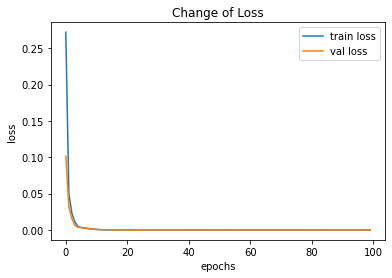

In [40]:
train_func(net)

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


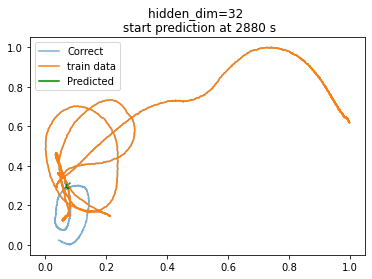

In [44]:
gen = future_prediction(net, df_for_pred)

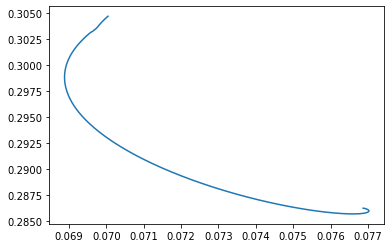

In [45]:
plt.plot(gen[:,0], gen[:,1])

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


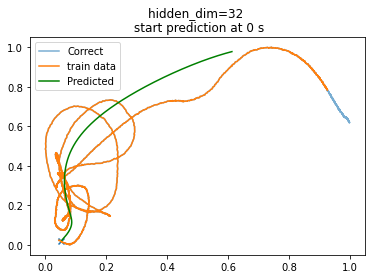

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


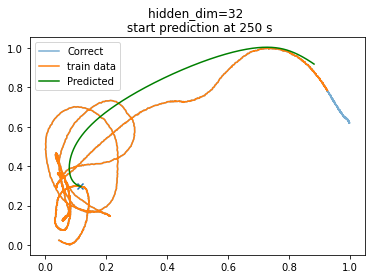

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


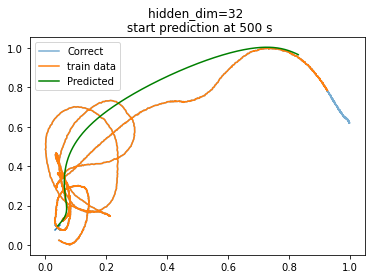

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


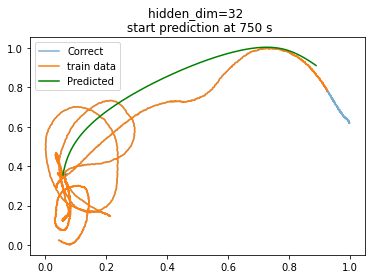

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


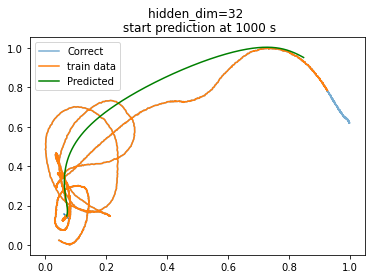

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


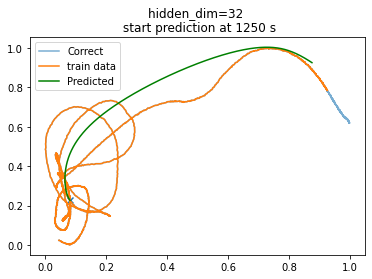

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


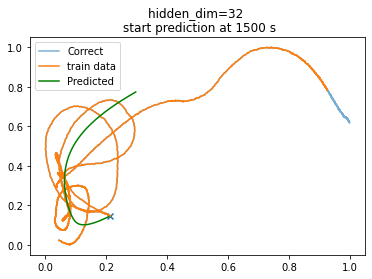

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


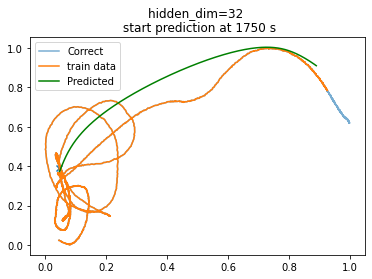

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


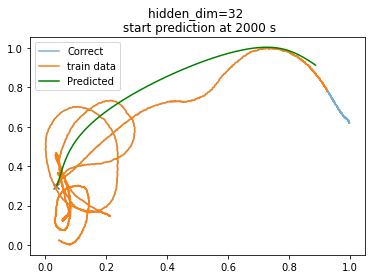

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


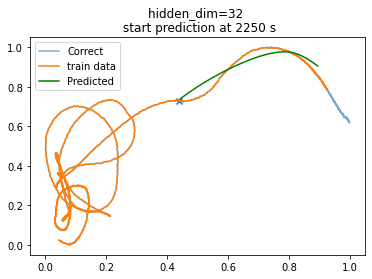

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


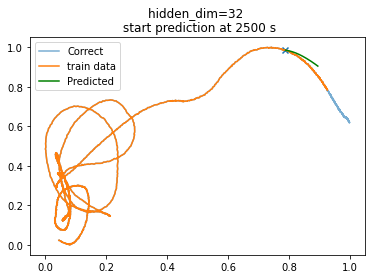

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


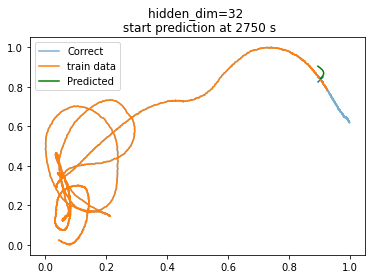

In [46]:
for s in range(0, train_size, 250):
    future_prediction(net, df_for_pred, s)

> メモ:時間が進めば進むほどプロットの距離が短くなるー＞学習データから「終わりがある」と学んでいるから？

Epoch:0, Train_Loss:0.137835, Val_Loss:0.024265
Epoch:5, Train_Loss:0.000465, Val_Loss:0.000193
Epoch:10, Train_Loss:0.000078, Val_Loss:0.000075
Epoch:15, Train_Loss:0.000064, Val_Loss:0.000063
Epoch:20, Train_Loss:0.000058, Val_Loss:0.000058
Epoch:25, Train_Loss:0.000054, Val_Loss:0.000056
Epoch:30, Train_Loss:0.000052, Val_Loss:0.000051
Epoch:35, Train_Loss:0.000048, Val_Loss:0.000050
Epoch:40, Train_Loss:0.000047, Val_Loss:0.000046
Epoch:45, Train_Loss:0.000045, Val_Loss:0.000044
Epoch:50, Train_Loss:0.000042, Val_Loss:0.000042
Epoch:55, Train_Loss:0.000044, Val_Loss:0.000040
Epoch:60, Train_Loss:0.000038, Val_Loss:0.000037
Epoch:65, Train_Loss:0.000035, Val_Loss:0.000039
Epoch:70, Train_Loss:0.000034, Val_Loss:0.000033
Epoch:75, Train_Loss:0.000034, Val_Loss:0.000034
Epoch:80, Train_Loss:0.000028, Val_Loss:0.000028
Epoch:85, Train_Loss:0.000028, Val_Loss:0.000031
Epoch:90, Train_Loss:0.000025, Val_Loss:0.000024
Epoch:95, Train_Loss:0.000027, Val_Loss:0.000022
Epoch:99, Train_Loss:0

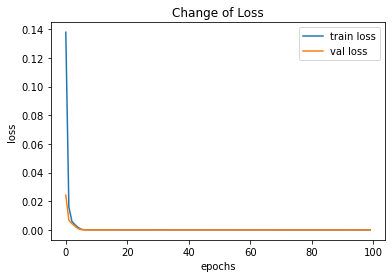

In [46]:
net2 = GRU(2,2,128,1)
train_func(net2, df_for_pred)

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


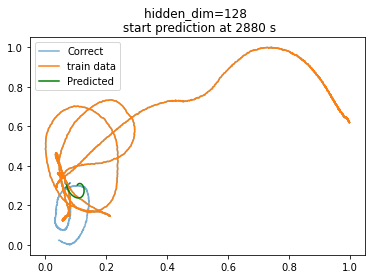

In [47]:
gen2 = future_prediction(net2, df_for_pred)

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


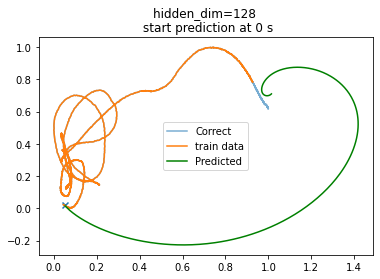

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


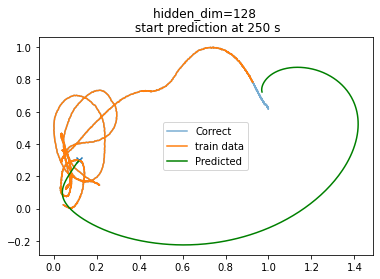

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


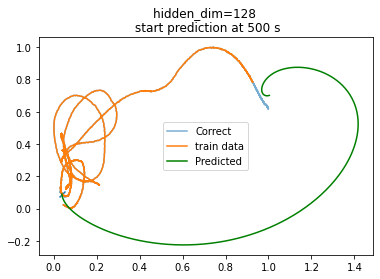

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


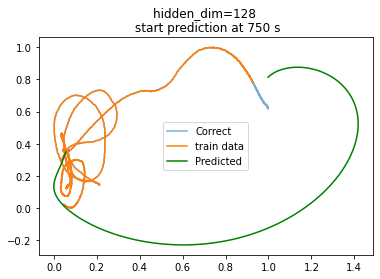

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


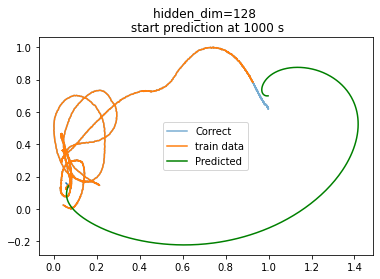

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


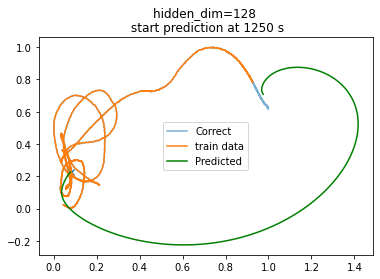

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


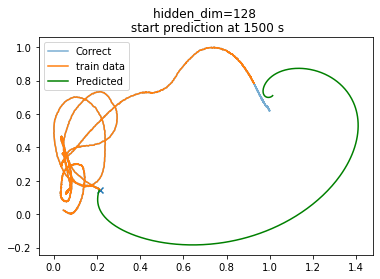

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


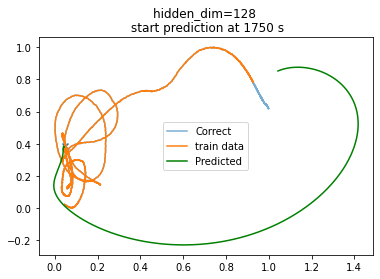

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


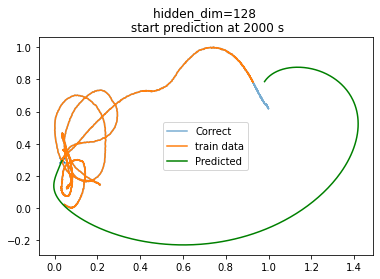

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


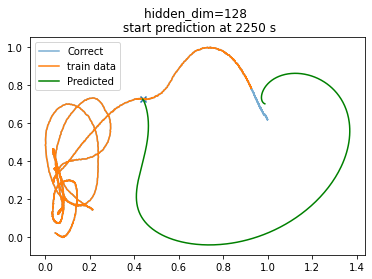

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


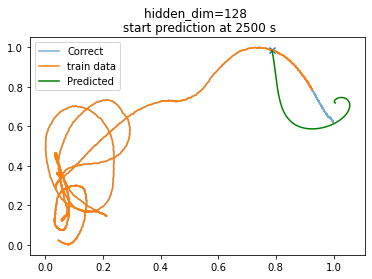

GRU(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


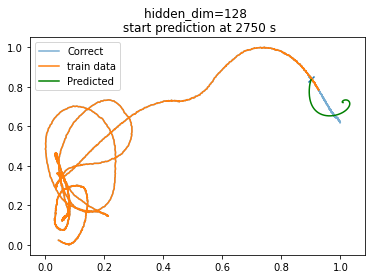

In [43]:
for s in range(0, train_size, 250):
    future_prediction(net2, df_for_pred, s)

Epoch:0, Train_Loss:0.057247, Val_Loss:0.006305
Epoch:5, Train_Loss:0.000093, Val_Loss:0.000084
Epoch:10, Train_Loss:0.000071, Val_Loss:0.000069
Epoch:15, Train_Loss:0.000062, Val_Loss:0.000061
Epoch:20, Train_Loss:0.000058, Val_Loss:0.000057
Epoch:25, Train_Loss:0.000055, Val_Loss:0.000054
Epoch:30, Train_Loss:0.000053, Val_Loss:0.000056
Epoch:35, Train_Loss:0.000051, Val_Loss:0.000056
Epoch:40, Train_Loss:0.000048, Val_Loss:0.000044
Epoch:45, Train_Loss:0.000047, Val_Loss:0.000041
Epoch:50, Train_Loss:0.000040, Val_Loss:0.000037
Epoch:55, Train_Loss:0.000037, Val_Loss:0.000039
Epoch:60, Train_Loss:0.000033, Val_Loss:0.000032
Epoch:65, Train_Loss:0.000032, Val_Loss:0.000027
Epoch:70, Train_Loss:0.000029, Val_Loss:0.000024
Epoch:75, Train_Loss:0.000023, Val_Loss:0.000020
Epoch:80, Train_Loss:0.000039, Val_Loss:0.000019
Epoch:85, Train_Loss:0.000017, Val_Loss:0.000018
Epoch:90, Train_Loss:0.000028, Val_Loss:0.000030
Epoch:95, Train_Loss:0.000015, Val_Loss:0.000022
Epoch:99, Train_Loss:0

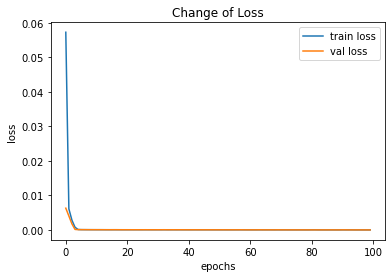

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


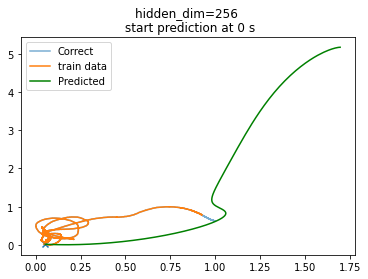

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


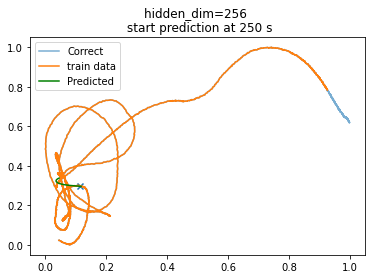

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


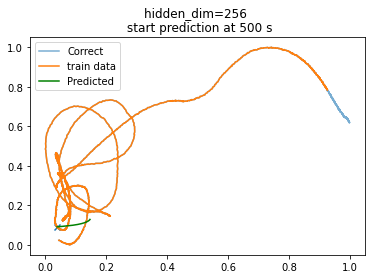

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


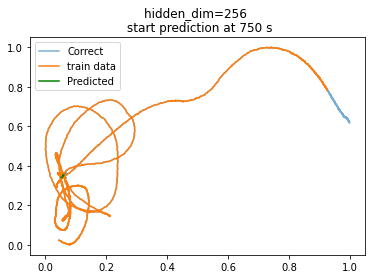

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


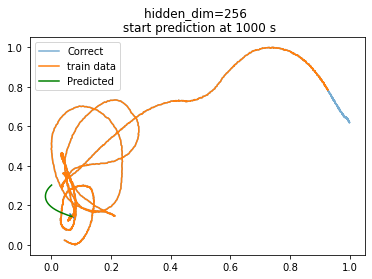

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


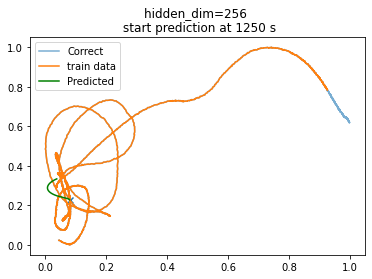

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


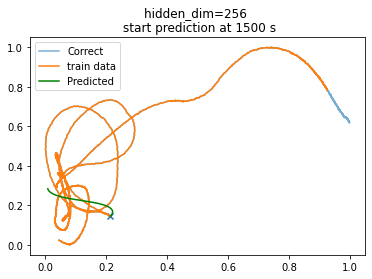

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


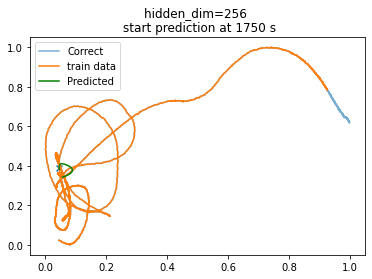

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


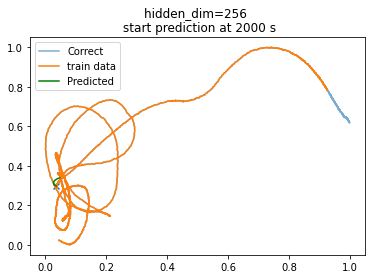

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


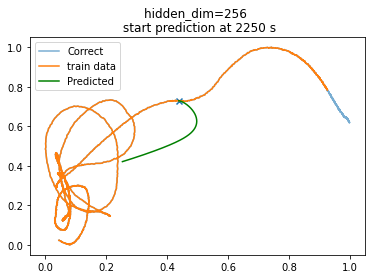

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


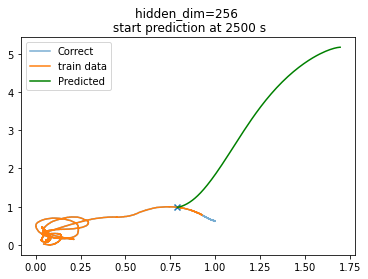

GRU(
  (gru): GRU(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


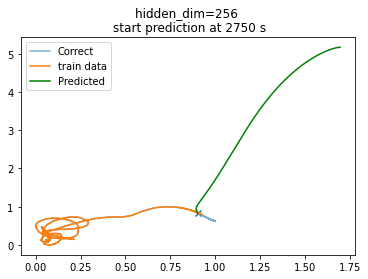

In [44]:
net3 = GRU(2,2,256,1)
train_func(net3, df_for_pred)
for s in range(0, train_size, 250):
    future_prediction(net3, df_for_pred,s)

In [47]:
df2 = mk_dataframe("230724/pos-2.dat")
df3 = mk_dataframe("230724/pos-3.dat")

In [48]:
df2 = df2.values
df3 = df3.values

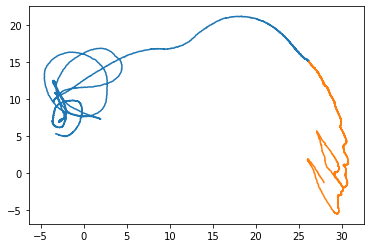

In [67]:
plt.plot(df_[::10, 0], df_[::10, 1])
plt.plot(df2[::10,0], df2[::10, 1])
# plt.plot(df3[::10,0], df3[::10, 1])

## 未知データへの適応

In [50]:
df2

array([[26.18625941, 14.97877824],
       [26.19289655, 14.97047845],
       [26.20218644, 14.9512839 ],
       ...,
       [27.979875  , -1.31464224],
       [27.95444053, -1.32135683],
       [27.9447619 , -1.32761905]])

GRU(
  (gru): GRU(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


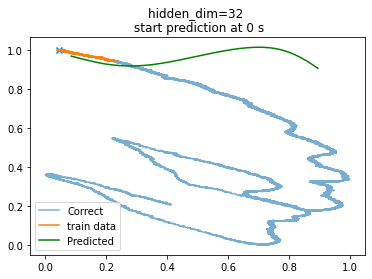

In [66]:
df2_ = scaler.fit_transform(df2)

gen = future_prediction(net, df2_, 0, 15000)

(0.0, 1.0)

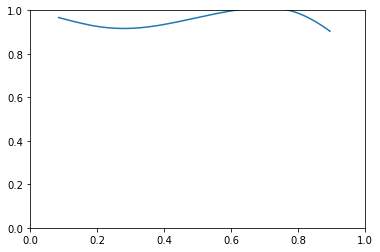

In [64]:
plt.plot(gen[:,0], gen[:,1])
plt.xlim(0,1)
plt.ylim(0,1)

In [325]:
torch.manual_seed(seed)
fc0 = nn.Linear(3, 2)

In [326]:
fc0.weight

Parameter containing:
tensor([[-0.0484, -0.0198, -0.2165],
        [ 0.1328, -0.3303, -0.1018]], requires_grad=True)

In [375]:
bn = nn.BatchNorm1d(5)

x_in = torch.tensor([[99, 10, 85, 90, 1],
                     [99, 25, 75, 90, 1],
                     [99, 30, 21, 90, 1],
                     [99, 15, 80, 90, 1],
                     [99, 12, 84, 91, 1],
                     [99, 20, 85, 91, 99]],
                    dtype=torch.float)

print(bn(x_in))

tensor([[ 6.4087e-04, -1.2189e+00,  5.8142e-01, -7.0710e-01, -4.4721e-01],
        [ 6.4087e-04,  8.9073e-01,  1.4536e-01, -7.0710e-01, -4.4721e-01],
        [ 6.4087e-04,  1.5939e+00, -2.2094e+00, -7.0710e-01, -4.4721e-01],
        [ 6.4087e-04, -5.1569e-01,  3.6339e-01, -7.0710e-01, -4.4721e-01],
        [ 6.4087e-04, -9.3761e-01,  5.3782e-01,  1.4142e+00, -4.4721e-01],
        [ 6.4087e-04,  1.8752e-01,  5.8142e-01,  1.4142e+00,  2.2361e+00]],
       grad_fn=<NativeBatchNormBackward0>)
